<a href="https://colab.research.google.com/github/griu/deeplearningupc/blob/master/8_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style

In this session we will use the approach described in [this paper](https://arxiv.org/abs/1508.06576) to apply a particular style to a content image by means of optimization using the weights of a pretrained convnet (VGG16).

Declare useful functions for later.

In [1]:
'''Neural style transfer with Keras.
# References
    - [A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576)
'''

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from keras.applications import vgg16
from keras import backend as K
import matplotlib.pyplot as plt  
%matplotlib inline
from keras.layers import Input
from scipy.misc import imread


# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path,img_nrows,img_ncols):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x,img_nrows,img_ncols):

    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == 'th':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination,img_nrows,img_ncols):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x,img_nrows,img_ncols):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



def eval_loss_and_grads(x,img_nrows,img_ncols,f_outputs):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self,img_nrows,img_ncols,f_outputs):
        self.loss_value = None
        self.grads_values = None
        self.img_nrows = img_nrows
        self.img_ncols = img_ncols
        self.f_outputs = f_outputs

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x,self.img_nrows,
                                                      self.img_ncols,
                                                      self.f_outputs)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Using TensorFlow backend.


Let's first display the images we chose. We want to transfer the style of the second image into the first one.

Cloning into '2017-persontyle'...
remote: Enumerating objects: 294, done.
remote: Total 294 (delta 0), reused 0 (delta 0), pack-reused 294
Receiving objects: 100% (294/294), 45.07 MiB | 10.39 MiB/s, done.
Resolving deltas: 100% (113/113), done.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


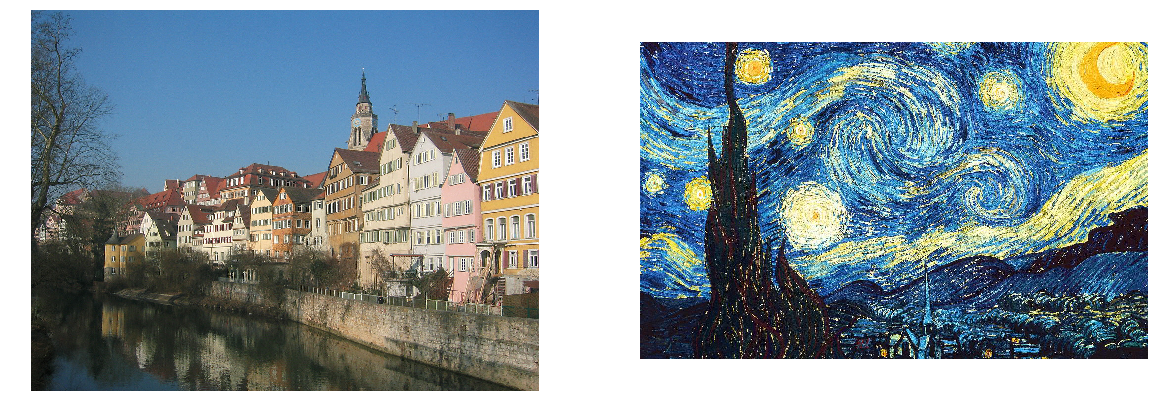

In [2]:
# We get the images from the following repository
!git clone https://github.com/telecombcn-dl/2017-persontyle.git

base_image_path = '2017-persontyle/images/neural_style/source/tubingen.jpg'
style_reference_image_path = '2017-persontyle/images/neural_style/style/starry_night.jpg'

f, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(imread(base_image_path))
axarr[0].axis('off')
axarr[1].imshow(imread(style_reference_image_path))
axarr[1].axis('off')
plt.show()

We load both images and create tensor representations of the appropriate size. We also define the ```input_tensor``` which will be the input that VGG expects.

In [3]:
from keras.preprocessing.image import load_img

width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path,img_nrows,img_ncols))
style_reference_image = K.variable(preprocess_image(style_reference_image_path,img_nrows,img_ncols))

combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# this is the tensor that we will use as input to VGG (the content, style, and the combination images concatenated)
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

Instructions for updating:
Colocations handled automatically by placer.


Load VGG and get a dictionary of all its layers:

In [4]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)

# get the symbolic outputs of each "key" layer
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

58900480/58889256 [==============================] - 5s 0us/step


Here we choose the layers of the network that we want to use to represent the style and the content. You can play with different combinations if you wish.

In [0]:
# content layers
content_layers = ['block4_conv2']

# style layers
style_layers = ['block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1',
                'block5_conv1']

Here we define the loss as the combination of the style and content losses:

In [12]:
style_weight = 0.7
content_weight = 0.3

# combine these loss functions into a single scalar
loss = K.variable(0.)

# loss for content layers
for layer_name in content_layers:
    layer_features = outputs_dict[layer_name]

    # we get the content features from the content image and the combination image
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    # content_loss is defined in style.py
    cl = content_loss(base_image_features,combination_features)
    loss += (content_weight / len(content_layers)) * cl

# loss for style layers
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    
    # get style features from style and combination images
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    # style_loss is defined in style.py
    sl = style_loss(style_reference_features, combination_features,img_nrows,img_ncols)
    loss += (style_weight / len(style_layers)) * sl

We will also include a third loss term, which encourages spatial smoothness in the generated image. Although this was not included in the original paper, it often improves results.

In [0]:
total_variation_weight = 1.0
# total_variation_loss is defined in style.py - preserves local coherence
loss += total_variation_weight*total_variation_loss(combination_image,img_nrows,img_ncols)

Next, we get the function that computes the gradient of the combination image with respect to the total loss.

In [0]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# final function that will give the gradients of the generated image wrt the loss
f_outputs = K.function([combination_image], outputs)

And now we iterate. At each iteration, the combination image ```x``` will be updated based on the gradients.

In [15]:
# the Evaluator class is defined in style.py
evaluator = Evaluator(img_nrows,img_ncols,f_outputs)

ims = []
iterations = 10

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

# we start with random image - this will be updated to be the combination of content and style images
x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.

for i in range(iterations):    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    
    print(i,'Current loss value:', min_val)
    # deprocess_image is defined in style.py
    img = deprocess_image(x.copy(),img_nrows,img_ncols)
    
    # append image to display later
    ims.append(img)

(0, 'Current loss value:', 28321001000.0)
(1, 'Current loss value:', 21642277000.0)
(2, 'Current loss value:', 19843066000.0)
(3, 'Current loss value:', 18970458000.0)
(4, 'Current loss value:', 18417125000.0)
(5, 'Current loss value:', 18029658000.0)
(6, 'Current loss value:', 17752568000.0)
(7, 'Current loss value:', 17544550000.0)
(8, 'Current loss value:', 17380164000.0)
(9, 'Current loss value:', 17245340000.0)


We will plot the images in the last 5 iterations.

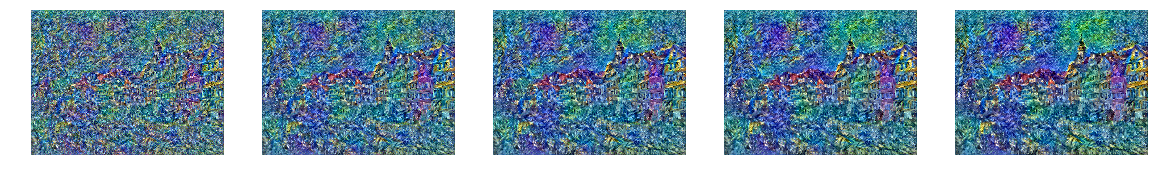

In [16]:
f, axarr = plt.subplots(1, len(ims[:5]),figsize=(20,20))

for i,im in enumerate(ims[:5]):
    axarr[i].imshow(im)
    axarr[i].axis('off')
plt.show()

We display the last image with higher resolution:

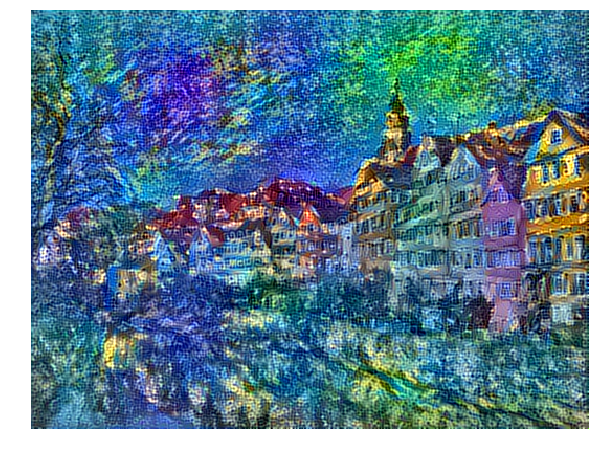

In [17]:
plt.figure(figsize=(10,10)) 
plt.imshow(ims[-1])
plt.axis('off')
plt.show()

**Exercise:** You can find more source and style images in the same folders as the ones we used in the example. Try with other images and see what happens. You can also experiment with different layers in the network, different weights, or different number of iterations. (Directory: `./2017-personstyle/images/neural_style/`). You can look at them by opening the menu at the top left of Colab.